<a href="https://colab.research.google.com/github/deepintomlf/mlfbook/blob/dev/Chapter8_ReinforcementLearning/RRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction




In the second part of this practice session, we will reformulate the Recurrent Reinforcement Learning (RRL) as the customized neural network model with Recurrent Neural Network(RNN) layer. Following [1] we will apply the RRL algorithm to learn optimal trading strategies on synthetic data.

This session aims to help you 


1.   deepen the understanding of RRL and RNN;
2.   implement the RNN model using Keras;
3.   master how to write the customized neural network in Keras.



## Recurrent Reinforcement Learning(RRL)
Recurrent Reinforcement Learning (RRL) is an adaptive approach of DR to solve the portfolio optimization problem, which can be simple re-interpreted as the RNN model. 

[[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=935097) Moody, J. and Saffell, M., 2001. Learning to trade via direct reinforcement. IEEE transactions on neural Networks, 12(4), pp.875-889.

**Goal**: To learn optimal trading stategy to maximize the Sharpe Ratio over the period.

**Problem setup**:


1.   $z_{t}$ is the price of the asset at time $t$;
2.   $r_{t}$ is the return at time $t$, i.e. $r_{t} = z_{t} - z_{t-1}$;
3.   $r_{t}^{f}$ is the risk-free return at time $t$;
4.   $F_{t}$ is the unit of the asset to trade at time $t$, where
\begin{eqnarray*}
F_{t} = \text{sign}\left({\color{blue}\mu} F_{t-1} + \sum_{ i = 0}^{p-1} {\color{blue}\nu_{i}} r_{t - i} + {\color{blue}\omega}\right),
\end{eqnarray*}
where $F_{t} \in \{ -1, 0, +1\}$, and ${\color{blue}\theta \equiv (\mu,\nu_{0} \cdots, \nu_{m}, \omega)}$ are model parameters
5.   $R_{t}$ is the trading return at time $t$, 
\begin{equation*}
R_{t} \equiv u \{ r_{t}^{f} + F_{t-1}(r_{t} - r_{t}^{f}) - \delta \vert F_{t} - F_{t-1} \vert \}.
\end{equation*}

The goal is to learn the optimal parameters to maximize the objective function (Sharpe Ratio $S_{T}$): 
\begin{eqnarray*}
S_{T} = \frac{\text{Average} (R_{t})}{\text{Standard Deviation} (R_{t})}.
\end{eqnarray*}

 ![alt text](https://docs.google.com/uc?export=download&id=1RuV5C928ow0JnSmlhP9tDp4arAUEbCrY)

## Recurrent Neural Network
1.  Input Layer $(x_{t})_{t = 1}^{T}$: 
2. Hidden Layer $(s_{t})_{t = 1}^{T}$:
\begin{eqnarray*}
s_{t} = h({\color{blue}U}x_{t} + {\color{blue}W}s_{t-1}).
\end{eqnarray*}
3. Output Layer $(o_{t})_{t = 1}^{T}$:
\begin{eqnarray*}
o_{t} = g({\color{blue}V}s_{t})，
\end{eqnarray*}
where ${\color{blue}\theta } \equiv (U, W, V) $ are RNN parameters to learn from data.

 ![alt text](https://docs.google.com/uc?export=download&id=1TdW2XhSyK0o7shHV_nh2ywt9gS142Fra)

#Data Simulation



We generate log price series $(p(t))_{t = 1}^{T}$ based on the following models:
\begin{eqnarray*}
p(t) &=& p(t-1) + \beta(t-1) + k \varepsilon(t),\\
\beta(t)& =&\alpha \beta(t-1) + \epsilon(t),
\end{eqnarray*}
where $\alpha = 0.9$ and $k =3$, $(\varepsilon(t),\epsilon(t))$ is a two dimensional standard normal distributed variable. The artificial price series $z(t)$ is defined as 
\begin{eqnarray*}
z(t) = \exp\left(\frac{p(t)}{R}\right),
\end{eqnarray*}
where $R: = \max_t(p(t)) - \min_t(p(t))$ over a simulation with $T = 10,000$.

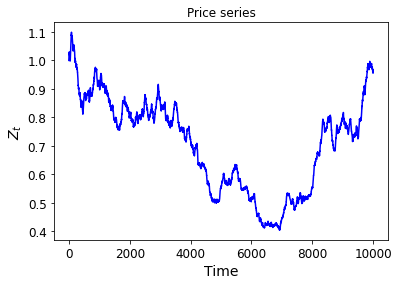

In [1]:
# import python packages
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# fix the random seed
np.random.seed(0)

def simulate_data(T):
  """
functionality: Simulate a time series p(t) of length T, which satisfies that
p[i+1] = p[i] + b[i] + 3e1[i];
b[i] = 0.9*b[i-1] + e2[i];
z = exp(p/range(p)).

  """
  b = np.zeros((T),  float)
  p = np.zeros((T),  float)
  b[0] = 0
  p[0] = 0
  for i in range(T-1):
      p[i+1] = p[i] + b[i] + 3 * np.random.randn()
      b[i+1] = 0.9 * b[i] + np.random.randn()       
  R = np.max(p) - np.min(p)
  z = np.exp(p/R)
  return z
  
T = 10000
z = simulate_data(T)

# Ploting price series v.s. time.
plt.plot(z, 'b')
plt.title('Price series')
plt.xlabel('Time')
plt.ylabel('$Z_t$')
plt.show()

# RRL Trading System

## Reformuation of RRL using RNN model





![alt text](https://docs.google.com/uc?export=download&id=129P7iYGliaNit4uf2qL8c9rE9SM_e48s)



## Preparing Data For the Learning Algorithm


In [0]:
def construct_multi_feature_time_series(market_info, id_t_start, id_t_end, n_lagged_time_steps ):
    """
    Functionality:
    To construct p-lagged return series X_ts and return series r_ts from price time series 
    market_info from any time period with index ranging from id_t_start to id_t_end
  
    Parameters:
    market_info (numpy): one-dimensional price time series
    id_t_start (int): the index of the starting time
    id_t_end (int): the index of the end time
    n_lagged_time_steps (int): the lagged values
  
    Returns:
    X_ts (numpy): the p-lagged return series
    r_ts (numpy): the return series
    """
    price = market_info[id_t_start:id_t_end] # 1-dimensional price time series starting at id_t_start and ending at id_t_end
    returnIndex = np.diff(price) # returnIndex(t) = price(t) - price(t-1) -- simple return series
    # Construct X_ts --the series of n_lagged_time_steps lagged values
    X_ts = np.zeros((len(price) - n_lagged_time_steps, n_lagged_time_steps)) 
    for i in range(X_ts.shape[0]):
        X_ts[i,:] = returnIndex[np.arange(i, i + n_lagged_time_steps,1)]
    r_ts = returnIndex[n_lagged_time_steps:]
    r_ts = np.append(r_ts, 0)
    r_ts = r_ts.reshape(np.shape(r_ts)+(1,))
    return X_ts, r_ts
  
# create the feature set and the next return series from the price data  
window_train = 2000
X_ts_train, r_ts_train = construct_multi_feature_time_series(z, id_t_start=0,  id_t_end = window_train, n_lagged_time_steps= 8)
X_ts, r_ts = construct_multi_feature_time_series(z, id_t_start= 0,  id_t_end =10000, n_lagged_time_steps= 8)

In [3]:
print(np.shape(X_ts_train))
print(np.shape(r_ts_train))
print(np.shape(X_ts))
print(np.shape(r_ts))

(1992, 8)
(1992, 1)
(9992, 8)
(9992, 1)


In [0]:
from sklearn import preprocessing

# normalization
window_train = 2000
scaler = preprocessing.StandardScaler().fit(X_ts_train)
X_ts_train = scaler.transform(X_ts_train)
X_ts = scaler.transform(X_ts)

 
 Here it is noted that the sample size = 1, 
 The model which we build later takes the input data [Xt, rt] with dim (T, p+1) maps to the output data with dim [T, p+1] 
 The output layer represents the trading return series
 The cumstomized Loss function is defind to be the Shapiro Ratio of the trading strategy

In [0]:
# Preparing the input data of the training set.
def reshape_input(X_ts, r_ts): 
  """ Parameters: X_ts - p-lagged values of return series [T, p]
                r_ts - the next value of return series [T, 1]
    Return: [1, nTimeSteps, nFeatures], where nTimeSteps = T, nFeatures = p+1"""
  #print(np.shape(X_ts))
  #print(np.shape(r_ts)) 
  X = np.concatenate([X_ts, r_ts], axis = 1)
  X= np.reshape(X, (1,)+np.shape(X))
  return X

trainX=reshape_input(X_ts_train, r_ts_train)
 

## Building a RRL model using Keras 




Let $x_t$ denote the $p$-lagged value of the return, i.e. $x_t  = (r_{t-p+1}, \cdots, r_{t})^{T}$.

1. **Input Layer** (Dark Green):  $(I_{t})_{t = p}^{T-1}$ where $I_{t} = \left( \begin{array}{c}x_{t}\\ r_{t+1}\\ \end{array} \right).$

2. **Hidden Layer** (Pink):  $(Y_{t})_{t = p}^{T-1}$ where  $Y_{t} = \left( \begin{array}{c} F_{t}\\ r_{t+1} \end{array} \right)$.  

  **Step 1**: We split the input layer into two parts: $(x_{t})_{t = p}^{T-1}$ and $(r_{t+1})_{t = p}^{T-1}$.

  **Step 2**: Set up the RNN Layer: $(x_{t})_{t = p}^{T-1} \rightarrow (F_{t})_{t = p}^{T-1}$ .

  **Step 3**: Merge  $(F_{t})_{t = p}^{T-1}$ and $(r_{t+1})_{t = p}^{T-1}$ to $(Y_{t})_{t = p}^{T-1}$. 
  

3. **Output Layer**(Blue):  $(R_{t})_{t = p}^{T-1}$, which can be directly computed from $(Y_{t})_{t = p}^{T-1}$  based on 
\begin{equation*}
R_{t} \equiv u \{ r_{t}^{f} + F_{t-1}(r_{t} - r_{t}^{f}) - \delta \vert F_{t} - F_{t-1} \vert \}.
\end{equation*}
for the given $r_{t}^{f}, \mu$ and $\delta$, as $Y_{t} = (F_{t}, r_{t+1})^{T}$.

4. **Loss Function**: 
\begin{eqnarray*}
S_{T} = \frac{\text{Average}(R_{t})}{\text{Standard Deviation}(R_{t})}
\end{eqnarray*}

![alt text](https://docs.google.com/uc?export=download&id=1SAkJwA7xis3B3wDN4h73ChH51tfZKhOB)

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import SimpleRNN, Dot, Dense, Activation, Input, Lambda, Add, Flatten,Multiply, Concatenate, Subtract
from tensorflow.keras.layers import Layer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
tf.random.set_seed(1)

In [0]:
# define lambda function to split
# split_func(x)
# output: the time series of p-lagged values

def split_func(x, p, flag):   
    split1, split2 = tf.split(x, [p, 1], -1)
    print(split1.shape)
    if flag == 1:
      return split1
    else: return split2
  
def trading_return(x, delta, T):
    F_t_Layer, r_tplus1_Layer = tf.split(x, [1, 1], -1)
    print('Ft.shape{}'.format(F_t_Layer.shape))
    F_tminus1_layer1, f1 = tf.split(F_t_Layer, [T, 1], -2)
    f1, F_t_layer1 = tf.split(F_t_Layer, [1, T], -2)
    transaction_part = delta*tf.abs(tf.subtract(F_t_layer1, F_tminus1_layer1))
    return_profit_layer  =  Multiply()([F_t_Layer, r_tplus1_Layer]) 
    f2, output_layer = tf.split(return_profit_layer, [1, T], -2)
    output_layer = output_layer-transaction_part
    return output_layer
  
def sharpe_ratio_loss(yTrue,yPred):
  y_shape = K.shape(yPred)
  B = K.mean(K.square(yPred))
  A = K.mean(yPred)
  return -A/((B-A**2)**0.5) 
  

def RRL_Model(input_dim, delta):
  model = Sequential()
  # initilize the input tensor with given shape (input_dim)
  print(input_dim)
  lagged_value = input_dim[-1]-1
  T = input_dim[0]-1
  print(lagged_value )
  print(T)
  input_layer = Input(shape= input_dim)
  # Step 1: Split the input layer into two parts: X_t_layer and r_tplus1_layer
  X_t_layer = Lambda(split_func, arguments={'p':lagged_value, 'flag':1})(input_layer)
  #print(X_t_layer.shape)
  r_tplus1_Layer = Lambda(split_func, arguments={'p':lagged_value, 'flag':2})(input_layer) 
  print('xt layer{}'.format(tf.shape(X_t_layer)) )
  # Step 2: Map X_t_alyer to F_t_layer using SimpleRNN()
  X_t_shape = X_t_layer.shape#[-2:]
  print(X_t_shape)
  F_t_Layer = SimpleRNN(1, input_shape= X_t_shape,activation = 'tanh', return_sequences = True, use_bias=True)(X_t_layer) # 
  # Step 3: Concatenate F_t_Layer with r_tplus1_Layer
  hidden_layer =  Concatenate()([F_t_Layer, r_tplus1_Layer])
  # Map hidden layer to output layer, which represents the trading return series
  output_layer  = Lambda(trading_return, arguments={'delta':delta, 'T':T})(hidden_layer )
  model = Model(inputs=input_layer, outputs=output_layer)

  #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  rms = optimizers.RMSprop(lr=0.01) 
  #model.compile(loss=sharpe_ratio_loss, optimizer=sgd)  
  model.compile(loss=sharpe_ratio_loss, optimizer=rms)  
  return model

In [8]:
np.shape(trainX)

(1, 1992, 9)

In [9]:
print(trainX[:, -1])

[[-0.78814515  1.66315172  0.59188398  0.25147794 -1.13724705  0.14006009
   0.18934997  1.09846267  0.        ]]


## Training Process

In [10]:
delta = 0.002
model = RRL_Model(np.shape(trainX)[1:], delta)
print(model.summary())

# Set callback functions to early stop training and save the best model so far
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor='train_loss', patience=2, min_delta=0.001),
             ModelCheckpoint(filepath='best_model.h5', monitor='train_loss', save_best_only=True)]

model.fit(trainX[:window_train], trainX[:window_train], epochs=800, callbacks=callbacks, verbose=2)
# model.fit(trainX[:window_train], trainX[:window_train], epochs=800,verbose=2)

(1992, 9)
8
1991
(None, 1992, 8)
(None, 1992, 8)
xt layerTensor("Shape:0", shape=(3,), dtype=int32)
(None, 1992, 8)
Ft.shape(None, 1992, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1992, 9)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1992, 8)      0           input_1[0][0]                    
__________________________________________________________________________________________________
simple_rnn (SimpleRNN)          (None, 1992, 1)      10          lambda[0][0]                     
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1992, 1)      

In [11]:
weights = model.get_weights()
print('The coefficients of p-lagged values: {}'.format(weights[0]))
print('The coefficients of the previous F(t-1): {}'.format(weights[1]))
print('The bias: {}'.format(weights[2]))

The coefficients of p-lagged values: [[0.02540901]
 [0.10499926]
 [0.07939119]
 [0.10956354]
 [0.22088787]
 [0.3261934 ]
 [0.41507548]
 [0.3693458 ]]
The coefficients of the previous F(t-1): [[1.7147706]]
The bias: [-0.4082543]


##Testing Process

Given $\theta$ and $F_{0} =0$, at each time $t$, we can evaluate the trading Strategy $F_{t}$:
\begin{eqnarray*}
F_{t} = \text{sign}\left({\color{blue}\mu} F_{t-1} + \sum_{ i = 0}^{p-1} {\color{blue}\nu_{i}} r_{t - i} + {\color{blue}\omega}\right),
\end{eqnarray*}
where $F_{t} \in \{ -1, +1\}$, and ${\color{blue}\theta \equiv (\mu,\nu_{0} \cdots, \nu_{m}, \omega)}$ are model parameters.

In [0]:
from numpy import divide, power 

def calc_next_window(weights, X_t, F_t):
  """ 
  Functionality: caludate the trading strategy at the next step.
  Parameters:
       weights: theta;
       X_t: the feature at current time t
       F_t: the trading strategy at current time t
  Returns:
       F_tplus1: the next trading strategy
  """
  weight0 = weights[0].reshape(np.shape(X_t))   
  F_tplus1 = np.sign(np.dot(weight0, X_t)+weights[1][0]*F_t + weights[2])
  return F_tplus1

def do_prediction(X, model, delta):
  weights = model.get_weights() 
  F = np.zeros(np.shape(X)[1], dtype = float)  
  R = np.zeros(np.shape(X)[1], dtype = float)  
  l = np.shape(F)[0]
  for i in range(l):  
    if i == 0:
      F[i] = calc_next_window(weights, X[0, i, :-1], 0)
    else:
      F[i] = calc_next_window(weights, X[0, i, :-1], F[i-1])
      R[i] = F[i-1]*X[0, i-1, -1]-delta*(np.abs(F[i] - F[i-1]))

  A = np.zeros(np.shape(F))
  B = np.zeros(np.shape(F))
  D = np.zeros(np.shape(F))
  var_R = np.zeros(np.shape(F))
  A[1:] = divide(np.cumsum(R)[1:], np.arange(l)[1:])
  B[1:] = np.divide(np.cumsum(np.power(R, 2))[1:], np.arange(l)[1:])
  var_R[2:] = B[2:]- power(A, 2)[2:]
  D[2:] =  A[2:]/ np.sqrt(var_R[2:])
  return F, R[:-1], D
                    

In [0]:
X = reshape_input(X_ts, r_ts)  
#X_train = reshape_input(X_ts_train, r_ts_train)  
#F_train, R_train, D_train = do_prediction(X_train, model, delta)
F, R, D = do_prediction(X, model, delta)

In [0]:
def plot_Price_F_Profit_SharpeR(r, F, R, D):
  plt.tight_layout()
  plt.subplots(3,1,figsize=(20,10))
  plt.subplot(3,1,1)
  plt.plot(F, 'b')
  plt.xlabel('Time')
  plt.ylabel('Signal')
  plt.subplot(3,1,2)
  plt.plot(np.cumsum(R), 'b', label="Moody-Saffell-RLL")
  plt.plot(np.cumsum(r), 'r',label="Buy-and-Hold")
  plt.xlabel('Time')
  plt.ylabel('Profit')
  plt.legend(loc="upper left")
  plt.subplot(3,1,3)
  plt.plot(D, 'b')
  plt.xlabel('Time')
  plt.ylabel('Sharpe ratio')
  plt.legend(loc="upper left")
  plt.tight_layout()
  plt.show()
  #plt.savefig('Result.png', dpi=1000)
  #files.download('Result.png')

def plot_average_weekly_return( R ):
    l = np.int(np.floor(np.shape(R)[0]/5))
    avgProfit = R[: l*5].reshape(l, 5)
    avgProfit = np.mean(avgProfit, 1)
    plt.hist(avgProfit, bins=50, color='b')
    plt.xlim((-0.01, 0.01))  
    
def plot_Hist_R_SharpR(R, D): 
  plt.subplots(3,2,figsize=( 17, 23))
  plt.subplot(3, 2, 1)
  plt.hist(R[:5000], 50, color='b')
  plt.xlabel('Reutrns')
  plt.ylabel('Freq')
  plt.title('t = 1: 5000')
  plt.subplot(3, 2, 2)
  plt.hist(R[5000:], 50, color='b')
  plt.xlabel('Returns')
  plt.ylabel('Freq')
  plt.title('t = 5000: 10000') 
  plt.subplot(3, 2, 3)
  plot_average_weekly_return(R[:5000])
  plt.xlabel('Profits')
  plt.ylabel('Freq')
  plt.title('t = 1:5000')
  plt.subplot(3, 2, 4)  
  plot_average_weekly_return(R[5000:])
  plt.xlabel('Profits')
  plt.ylabel('Freq')
  plt.title('t = 5000:10000')
  plt.subplot(3, 2, 5)
  plt.hist(D[:5000], 80, color='b')
  plt.xlabel('Sharpe ratio')
  plt.ylabel('Freq')
  plt.title('t = 1: 5000')
  plt.subplot(3, 2, 6)
  plt.hist(D[5000:], 80, color='b')
  plt.xlabel('Sharpe ratio')
  plt.ylabel('Freq')
  plt.title('t = 5000: 10000')
#  plt.savefig('RRL_hist_Result.png', dpi=1000)
  plt.tight_layout()
 # files.download('RRL_hist_Result.png')
  plt.show()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

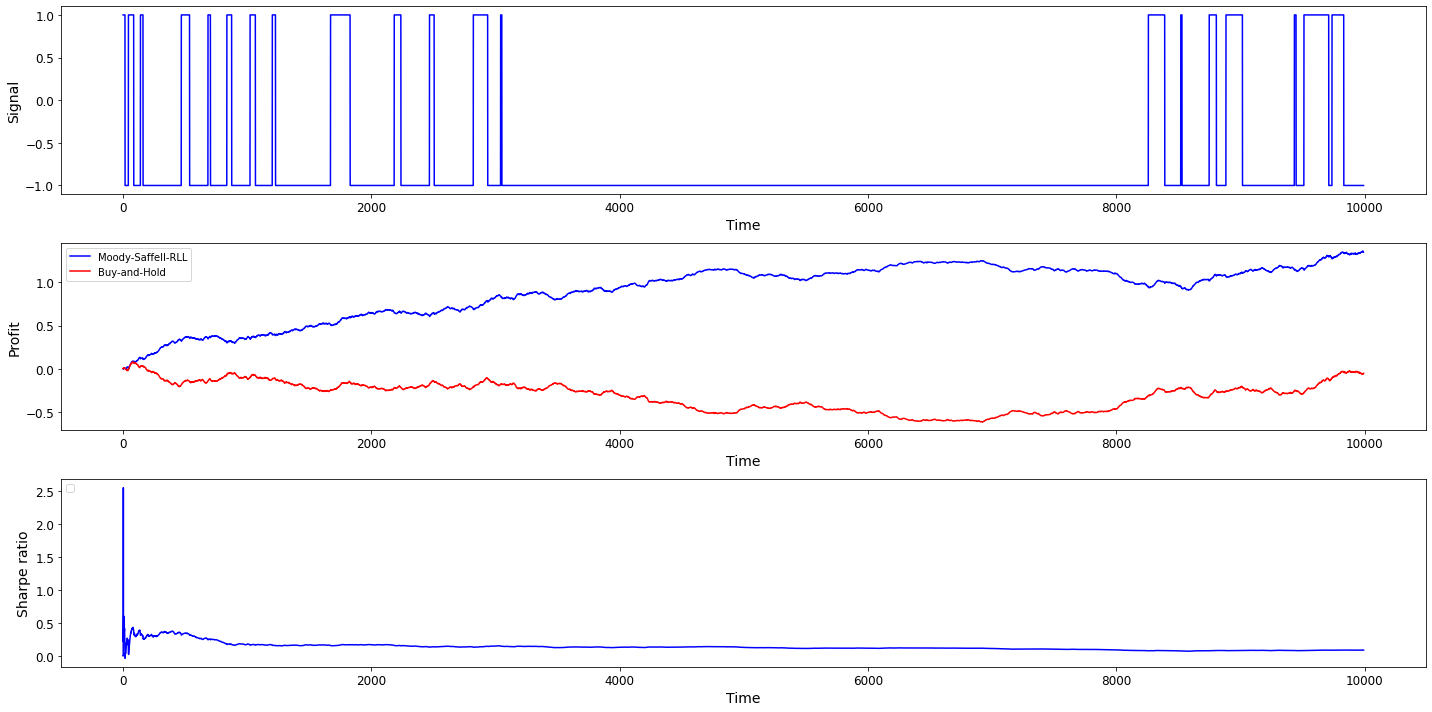

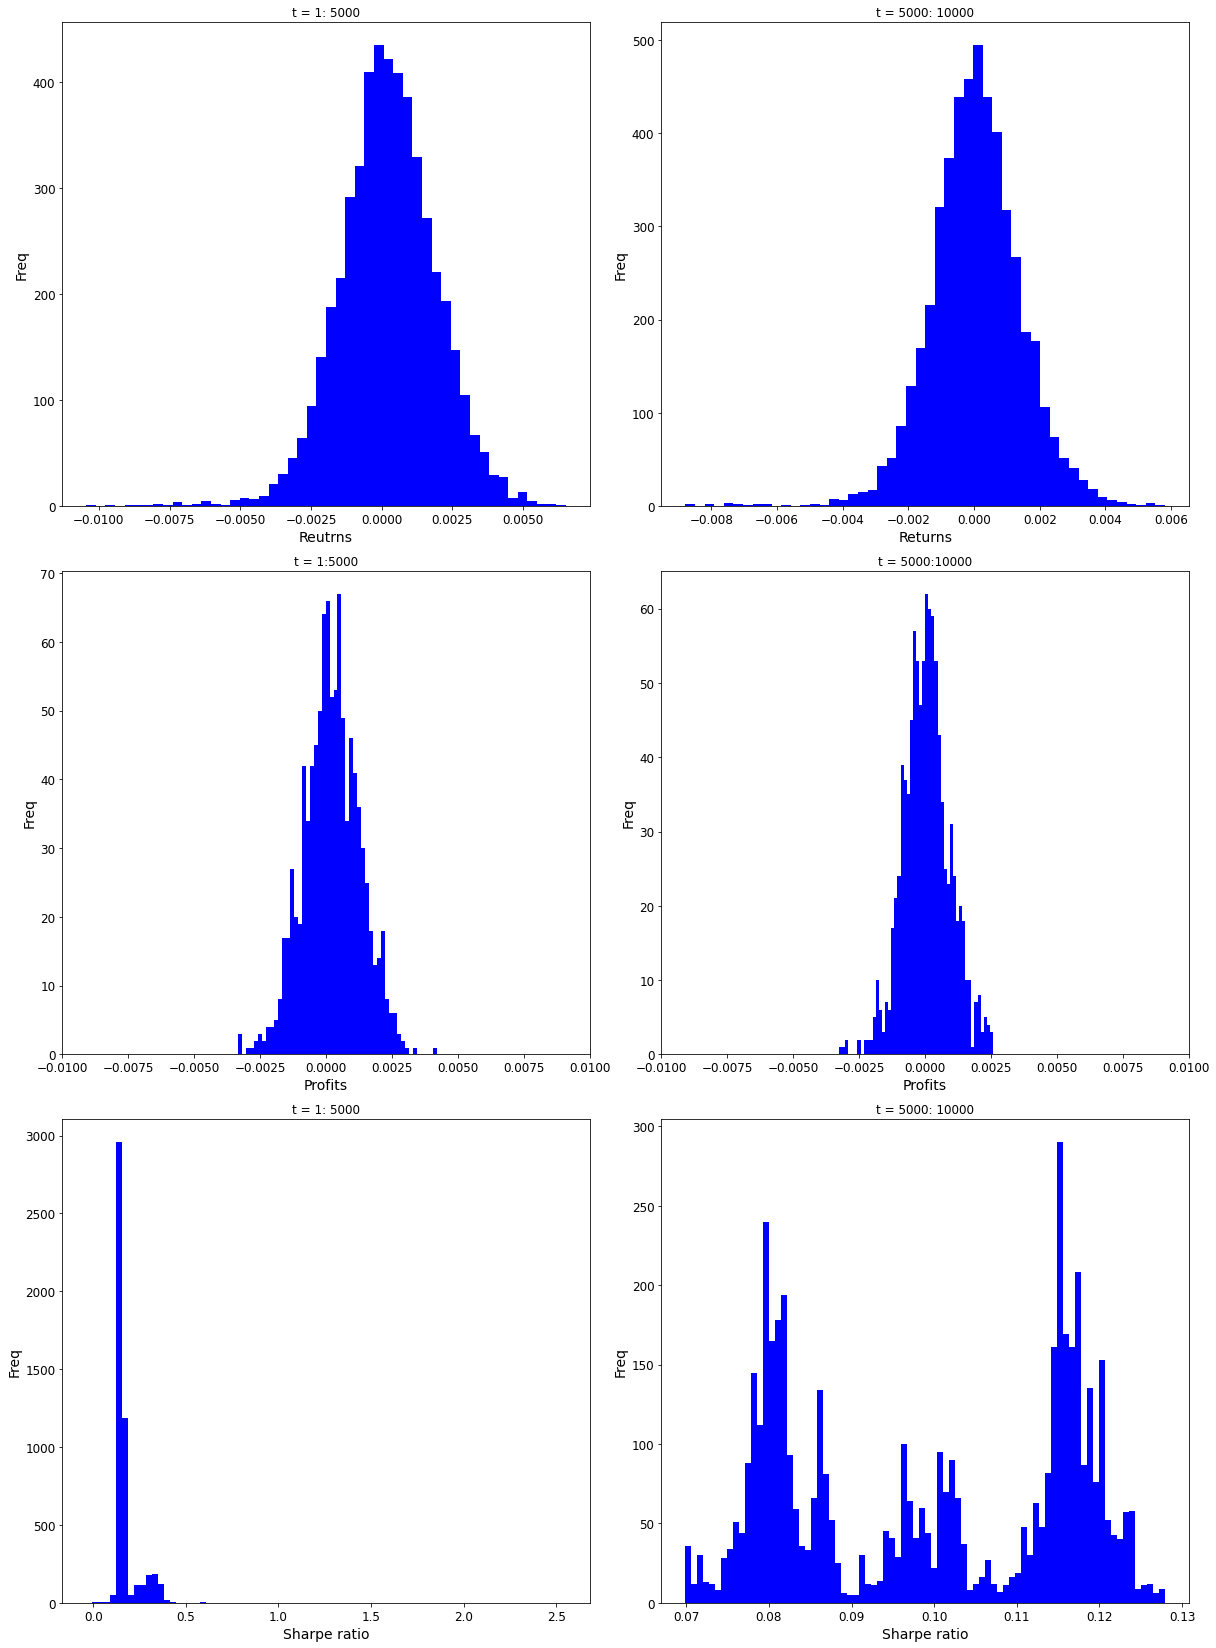

In [15]:
plot_Price_F_Profit_SharpeR(r_ts, F, R, D)
plot_Hist_R_SharpR(R, D)

# Future Work



1.  Synthetic Data:

      (1)  When the transaction cost parameter $\delta$ is large, the above algorithm is not stable; 
      
      (2)  Consider the differential Sharpe Ratio as the utility function to further improve the efficiency of the algorithm.
      
2.  Empirical Data: How to choose the external variables?

3. Other methods to derive the optmial trading strategy?

